In [ ]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# for getting summary info on models
from torchsummary import summary

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [ ]:
data = np.loadtxt(open('sample_data/mnist_train_small.csv', 'rb'), delimiter = ',')

# extract labels and remove from data
labels = data[:, 0]
data = data[:, 1:]

# normalize the data from range of [0 1]
dataNorm = data / np.max(data)

# Reshape to 2D
dataNorm = dataNorm.reshape(dataNorm.shape[0], 1, 28, 28)

In [ ]:
dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long()

# splitting the data
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT, test_size = 0.2)

# converting it into pytorch dataset
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# translate into dataloader objects
batchsize = 32
train_loader = DataLoader(train_data, batch_size = batchsize, shuffle = True)
test_loader = DataLoader(test_data, batch_size = len(test_data))


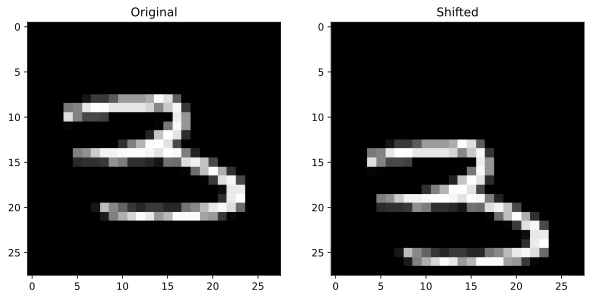

In [ ]:
tmp = test_loader.dataset.tensors[0][0,:]

# # shift the image
tmpS = torch.roll(tmp, 5, dims = 1)

fig, ax = plt.subplots(1, 2, figsize = (10, 6))

ax[0].imshow(torch.squeeze(tmp), cmap = 'gray')
ax[0].set_title('Original')

ax[1].imshow(torch.squeeze(tmpS), cmap = 'gray')
ax[1].set_title('Shifted')

plt.show()

In [ ]:
for i in range(train_loader.dataset.tensors[0].shape[0]):

    # get the image
    img = train_loader.dataset.tensors[0][i, :, :]

    # reshape and roll
    randroll = np.random.randint(-10, 11)
    img = torch.roll(img, randroll, dims = 1)

    # re-vectorize it and put it back into the matrix
    train_loader.dataset.tensors[0][i, :, :] = img


In [ ]:
for i in range(test_loader.dataset.tensors[0].shape[0]):

    img = test_loader.dataset.tensors[0][i, :, :]

    # reshape and roll
    randroll = np.random.randint(-10, 11)
    img = torch.roll(img, randroll, dims = 1)

    # re-vectorize
    test_loader.dataset.tensors[0][i, :, :] = img


In [ ]:
def createTheMNISTNet(printtoggle = False):

    class mnistNet(nn.Module):
        def __init__(self, printtoggle):
            super().__init__()

            ## convolutional layers
            self.conv1 = nn.Conv2d(1, 10, kernel_size = 5, stride = 1, padding = 1)
            # size: np.float((28 + 2 * 1 - 5)/1) + 1 = 26 and maxpooling it 26/2 = 13

            self.conv2 = nn.Conv2d(10, 20, kernel_size = 5, stride = 1, padding = 1)
            # size: np.float((13 + 2 * 1 - 5)/1) + 1 = 11 and maxpooling it 11/2 = 5

            expectSize = np.floor((5 + 2*0 - 1)/1) + 1  # fc1 layer has no padding or kernel
            expectSize = 20 * int(expectSize**2)

            # fully connected layer
            self.fc1 = nn.Linear(expectSize, 50)

            # output layer
            self.out = nn.Linear(50, 10)

            # toggle for printing out tensor sizes during the forward prop
            self.print = printtoggle

        def forward(self, x):

            print(f'Input: {x.shape}') if self.print else None

            # 1. convolution -> maxpool -> relu
            x = F.relu(F.max_pool2d(self.conv1(x), 2))
            print(f'Layer conv1/pool1: {x.shape}') if self.print else None

            # 2. convolution -> maxpool -> relu
            x = F.relu(F.max_pool2d(self.conv2(x), 2))
            print(f'Layer conv2/pool2: {x.shape}') if self.print else None

            # reshape for linear layer
            nUnits = x.shape.numel()/x.shape[0]
            x = x.view(-1, int(nUnits))
            if self.print: print(f'Vectorize: {x.shape}')


            # linear layers
            x = self.fc1(x)
            if self.print: print(f'Layer fc1: {x.shape}')
            x = self.out(x)
            if self.print: print(f'Layer out: {x.shape}')

            return x

    # create the model instance
    net = mnistNet(printtoggle)

    # loss function
    lossfun = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr = .001)

    return net, lossfun, optimizer


In [ ]:
# test the model with one batch
net, lossfun, optimizer = createTheMNISTNet(True)

X, y = next(iter(train_loader))
yHat = net(X)

# checking sizes of model outputs and target variable
print(' ')
print(yHat.shape)
print(y.shape)

# now lets compute the loss
loss = lossfun(yHat, y)
print(' ')
print('Loss: ')
print(loss)

Input: torch.Size([32, 1, 28, 28])
Layer conv1/pool1: torch.Size([32, 10, 13, 13])
Layer conv2/pool2: torch.Size([32, 20, 5, 5])
Vectorize: torch.Size([32, 500])
Layer fc1: torch.Size([32, 50])
Layer out: torch.Size([32, 10])
 
torch.Size([32, 10])
torch.Size([32])
 
Loss: 
tensor(2.3292, grad_fn=<NllLossBackward0>)


In [ ]:
def function2TrainTheModel():

    numepochs = 50

    # create a new model
    net, lossfun, optimizer = createTheMNISTNet()

    # initialize losses
    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    for epochi in range(numepochs):

        net.train()
        batchAcc = []
        batchLoss = []

        for X, y in train_loader:

            yHat = net(X)
            loss = lossfun(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
            matches = torch.mean((torch.argmax(yHat, axis = 1) == y).float())
            accuracypct = 100*matches
            batchAcc.append(accuracypct)

        trainAcc.append(np.mean(batchAcc))
        losses[epochi] = np.mean(batchLoss)

        net.eval()
        X, y = next(iter(test_loader))
        with torch.inference_mode():
            yHat = net(X)
            matches = torch.mean((torch.argmax(yHat, axis = 1) == y).float())
            accuracypct = 100*matches
            testAcc.append(accuracypct)

    return trainAcc, testAcc, losses, net





In [ ]:
trainAcc, testAcc, losses, net = function2TrainTheModel()

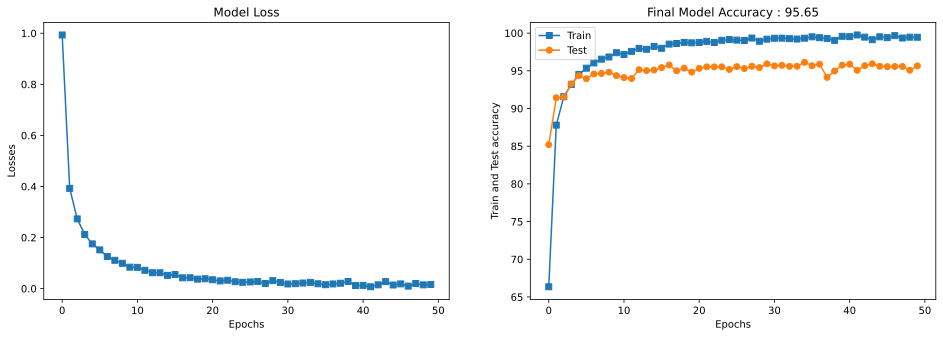

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))

ax[0].plot(losses, 's-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Losses')
ax[0].set_title('Model Loss')

ax[1].plot(trainAcc, 's-', label = 'Train')
ax[1].plot(testAcc, 'o-', label = 'Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Train and Test accuracy')
ax[1].set_title(f'Final Model Accuracy : {testAcc[-1]:.2f}')
ax[1].legend()

plt.show()